# Espectro sonoro

- PET - Fisica UFRN
- Petiano: Gustavo C. A. Vilas Boas
- 10/02/21

O objetivo deste projeto é visualizar uma onda sonora e seu espectro, utilizando transformada de Fourier, e a partir disso gerar um novo arquivo de áudio com o ruído diminuído. E como bônus analisar o som captado pelo microfone.

## Introdução

A transformada de Fourier é uma das ferramentas mais usadas na física, pois é capaz de decompor funções ou sinais que dependem do tempo em frequências, permitindo observar quais frequências constituem a função, como as notas em um acorde ou a frequência do ciclo solar, como foi abordado anteriormente. 
As ondas sonoras, como o próprio nome diz, são ondas, e como qualquer função $f(x)$ (que atende às condições de Dirichlet), podem ser descritas como uma soma de senos e cossenos[1].

$$f(x) = \sum_{k=0}^{\infty} \alpha_k cos\Big(\frac{2 \pi kx}{L}\Big) + \sum_{k=1}^{\infty} \beta_k sen\Big(\frac{2 \pi kx}{L}\Big)$$

Ou reescrevendo na forma complexa:

$$f(x) = \sum_{k=-\infty}^{\infty} \gamma_k exp\Big(i\frac{2 \pi kx}{L}\Big)$$

$$
\gamma_k = \begin{cases}
                \frac{1}{2}(\alpha_{-k} + i\beta_{-k}) & if\,\, k < 0,\\ 
                \alpha_0 & if\,\, k = 0,\\
                \frac{1}{2}(\alpha_{k} - i\beta_{k}) & if\,\, k > 0. \\
            \end{cases}
$$

Porém o que queremos é uma função no domínio das frequências, e não do tempo como a função $f(x)$, e para isso, utilizamos a Transformada de Fourier:

$$\gamma_k = \frac{1}{N} \sum_{k=0}^{N-1} f(x_n) exp \Big(-i\frac{2 \pi kx}{L}\Big)$$

## Importando bibliotecas

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from numpy.fft import rfft, irfft
import numpy as np

Além dessas quatro bibliotecas que utilizaremos para a primeira parte, teremos mais algumas para a segunda parte.

In [2]:
import pyaudio
import struct
from tkinter import TclError

## Leitura e tratamento do arquivo de áudio

Utilizaremos a função ***wavfile*** do ***scipy.io*** para ler o arquivo ***.wav*** de uma gravação da introdução da música *Stairway to Heaven* da banda *Led Zeppelin* tocada em um violão, com som de chuva e ventilador perto. 

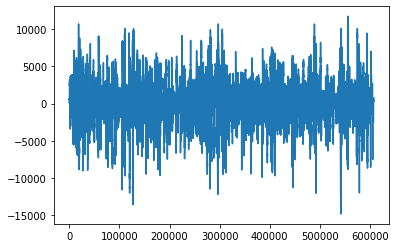

In [3]:
rate, data = wav.read('led.wav')
plt.plot(data)
plt.show()

Agora, para obtermos o gráfico dos coeficientes no domínio das frequências, utilizaremos a função ***rfft***.

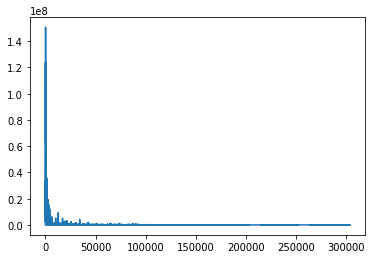

In [4]:
fft_data = rfft(data)
plt.plot(np.abs(fft_data))
plt.show()

Percebe-se que a partir de um certo ponto, vemos apenas frequências com valores muito pequenos, que podem ser retirados para suavizar a onda sonora, retirando assim, um pouco do ruído.

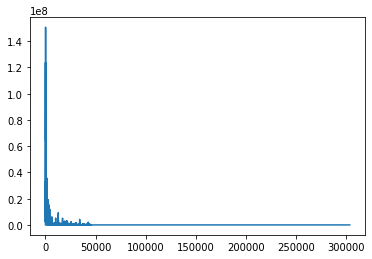

In [5]:
N = len(fft_data)
fft_data2 = np.zeros(N, complex)
pfreq = 0.15 # Porcentagem restante das frequências
for i in range(N):
    if i < (pfreq*N):
        fft_data2[i] = fft_data[i]
plt.plot(np.abs(fft_data2))
plt.show()

E finalmente, para criar nosso arquivo ***.wav*** com essa alteração, utilizaremos a função inversa ***irrft*** e após isso, utilizar o ***wav.write*** para criar o novo arquivo ***led2.wav***

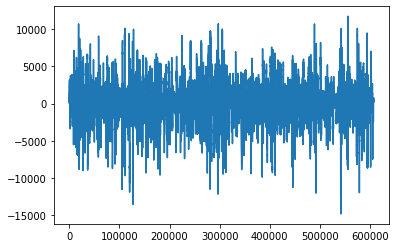

In [6]:
data2 = irfft(fft_data2)
plt.plot(data2)
plt.show()

wav.write('led2.wav',rate,data2.astype(np.int16))

Percebe-se que ao alterar a porcentagem, o som resultante se altera, tomando um aspecto mais "abafado" quando diminuído, diminuindo o ruído, porém perdendo um pouco da qualidade. Nesse arquivo infelizmente não foi possível retirar o som do ventilador pois estava alto e continua perceptível após o processo.

## Análise em tempo real do microfone

Não falarei tanto sobre os detalhes técnicos do código, pois não é meu, fiz apenas algumas poucas alterações, mas adicionarei aqui por ser uma utilização muito interessante do assunto. O autor original tem um video explicando o passo a passo [2].

In [7]:
# Usado para abrir uma janela a parte
%matplotlib tk

# Constantes
amostra = 1024 * 2             # Amostras por frame
taxa = 44100                 # Amostras por segundo

# Criação da figura e eixos
#plt.ion()              #(Usado para abrir no python, no lugar do %matplotlib tk)
fig, (ax1, ax2) = plt.subplots(2)

# Iniciação do PyAudio
p = pyaudio.PyAudio()

# Objeto para receber os dados do microfone
stream = p.open(
    format=pyaudio.paInt16,
    channels=1,
    rate=taxa,
    input=True,
    output=True,
    frames_per_buffer=amostra
)

# Variaveis para o plot
x = np.arange(0, 2 * amostra, 2)       # Amostras (Onda)
xf = np.linspace(0, taxa, amostra)     # Frequências (Espectro)

# Criação de uma linha para a onda
line, = ax1.plot(x, np.random.rand(amostra), '-', lw=2)

# Criação de uma linha para o espectro (com semilogx para visualizar melhor)
line_fft, = ax2.semilogx(xf, np.random.rand(amostra), '-', lw=2)

# Eixos para formato da onda
ax1.set_title('Onda sonora')
ax1.set_xlabel('Amostras')
ax1.set_ylabel('Amplitude')
#ax1.set_ylim(0, 255)
ax1.set_xlim(0, 2 * amostra)
plt.setp(ax1, xticks=[0, amostra, 2 * amostra], yticks=[0, 128, 255])

# Eixos para espectro
ax2.set_xlim(20, taxa / 2)
ax2.set_ylim(0,1)


while True:
    
    # Dados binários
    data = stream.read(amostra)  
    
    # Conversão em integers
    data_int  = struct.unpack(str(2 * amostra) + 'B', data)
    
    # Criação de array
    data_np = np.array(data_int, dtype='b')[::2] + 128
    
    line.set_ydata(data_np)
    
    # Cálculo da transformada de Fourier
    yf = rfft(data_int)
    line_fft.set_ydata(np.abs(yf[0:amostra])  / (128 * amostra)) 
    
    # Atualização da tela
    try:
        fig.canvas.draw()
        fig.canvas.flush_events()
        
    except TclError:
        break

## Referências

[1] Mark Newman-Computational Physics (2013,University of Michigan)    
[2] Mark Jay. https://www.youtube.com/watch?v=aQKX3mrDFoY